In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = False
show_intermediate_plots = False
check_cond = False
print_features = False

plot_dir = '../plots/plots_2022-03-09'
if save_plots:
    !mkdir -p $plot_dir

# r_edges (TNG50-4: L=35 Mpc/h, N_part=270^3, mean interparticle spacing = 35/270 = 0.13 Mpc/h = 130 kpc/h)
# for scalars, only 0 or 2 x orders 
n_rbins_arr = np.array([4])
m_order_max_arr = [3]
x_order_max_arr = [0] 
v_order_max_arr = [0]
include_eigenvalues = False
include_eigenvectors = False

y_scalar_feature_name='mass_hydro_subhalo_star'

r_units = 'r200'
rms_x = True
log_x = False
log_y = False

#tag = ''
tag = '_uncgenel'
if include_eigenvalues:
    tag += '_eigvals'

l_arr, p_arr = scalars.get_needed_vec_orders_scalars(max(x_order_max_arr), max(v_order_max_arr))

In [3]:
mass_multiplier = 1e10

In [4]:
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
snap_num_str = '099' # z = 0

In [5]:
num_star_particles_min = 1
halo_mass_min = 10**10.8
halo_mass_min_str = '1e10.8'
halo_mass_max = None
halo_mass_max_str = None
halo_mass_difference_factor = 3.0
subsample_frac = None

In [6]:
featurizer = Featurizer(base_dir, sim_name, sim_name_dark, snap_num_str)
featurizer.load_halo_dicts(num_star_particles_min=num_star_particles_min, 
                           halo_mass_min=halo_mass_min, halo_mass_min_str=halo_mass_min_str, 
                           halo_mass_max=halo_mass_max, halo_mass_max_str=halo_mass_max_str, 
                           halo_mass_difference_factor=halo_mass_difference_factor,
                           subsample_frac=subsample_frac,
                           force_reload=False)
featurizer.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)

Halo file ../data/halo_dicts/halo_dicts_TNG100-1_nstarmin1_hmassmin1e10.8_mdifffac3.0.npy exists, loading
20098 halos in matched, selected halo dicts


In [7]:
print(np.sum(featurizer.y_scalar==0))

0


In [8]:
feature_dir = f'../data/features/features_{sim_name}/halos{featurizer.halo_tag}'

In [9]:
# Inputs to SHMR broken power law:
# N: the normalization of the SHM ratio 
# M1: a characteristic mass 
# β and γ: indicate the behavior of m/M at the low and high-mass ends
def broken_power_law_feature(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [10]:
m200_halo = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])
y_val_current = broken_power_law_feature(m200_halo)

In [11]:
uncertainty_floor = 2e8/mass_multiplier
uncertainties_orig = np.sqrt((0.1*featurizer.y_scalar)**2 + uncertainty_floor**2) # uncertainties are 0.1*M_stellar (M_stellar is our label)

In [12]:
logmstellar_bins = np.linspace(8.5, 11, 6)
logmstellar_bins = np.array([5] + list(logmstellar_bins) + [13])
print(logmstellar_bins)
# added estimates on either end
stdev_dict = {'TNG50-4': np.array([0.4, 0.28, 0.23, 0.12, 0.05, 0.04, 0.04]), # epsilon=4, similar to tng50-4
              'TNG100-1': np.array([0.15, 0.08, 0.06, 0.04, 0.03, 0.04, 0.04]), # epsilon=1, similar to tng100-1
             }

logyscalar = np.log10(featurizer.y_scalar*mass_multiplier)
idxs_mbins = np.digitize(logyscalar, logmstellar_bins)

stdevs = stdev_dict[sim_name][idxs_mbins-1]
uncertainties = stdevs * featurizer.y_scalar * np.log(10.0)
# hack to deal with 0-stellar-mass objects
uncertainties[uncertainties==0] = stdev_dict[sim_name][0] * 10**logmstellar_bins[0]/mass_multiplier
print(stdev_dict[sim_name][0]*10**logmstellar_bins[0]/mass_multiplier, 2e8/mass_multiplier)

[ 5.   8.5  9.   9.5 10.  10.5 11.  13. ]
1.5e-06 0.02


In [13]:
#uncertainties = np.sqrt(uncertainties**2 + uncertainties_orig**2) # uncertainties are 0.1*M_stellar (M_stellar is our label)

Text(0, 0.5, '$M_\\mathrm{stellar}$')

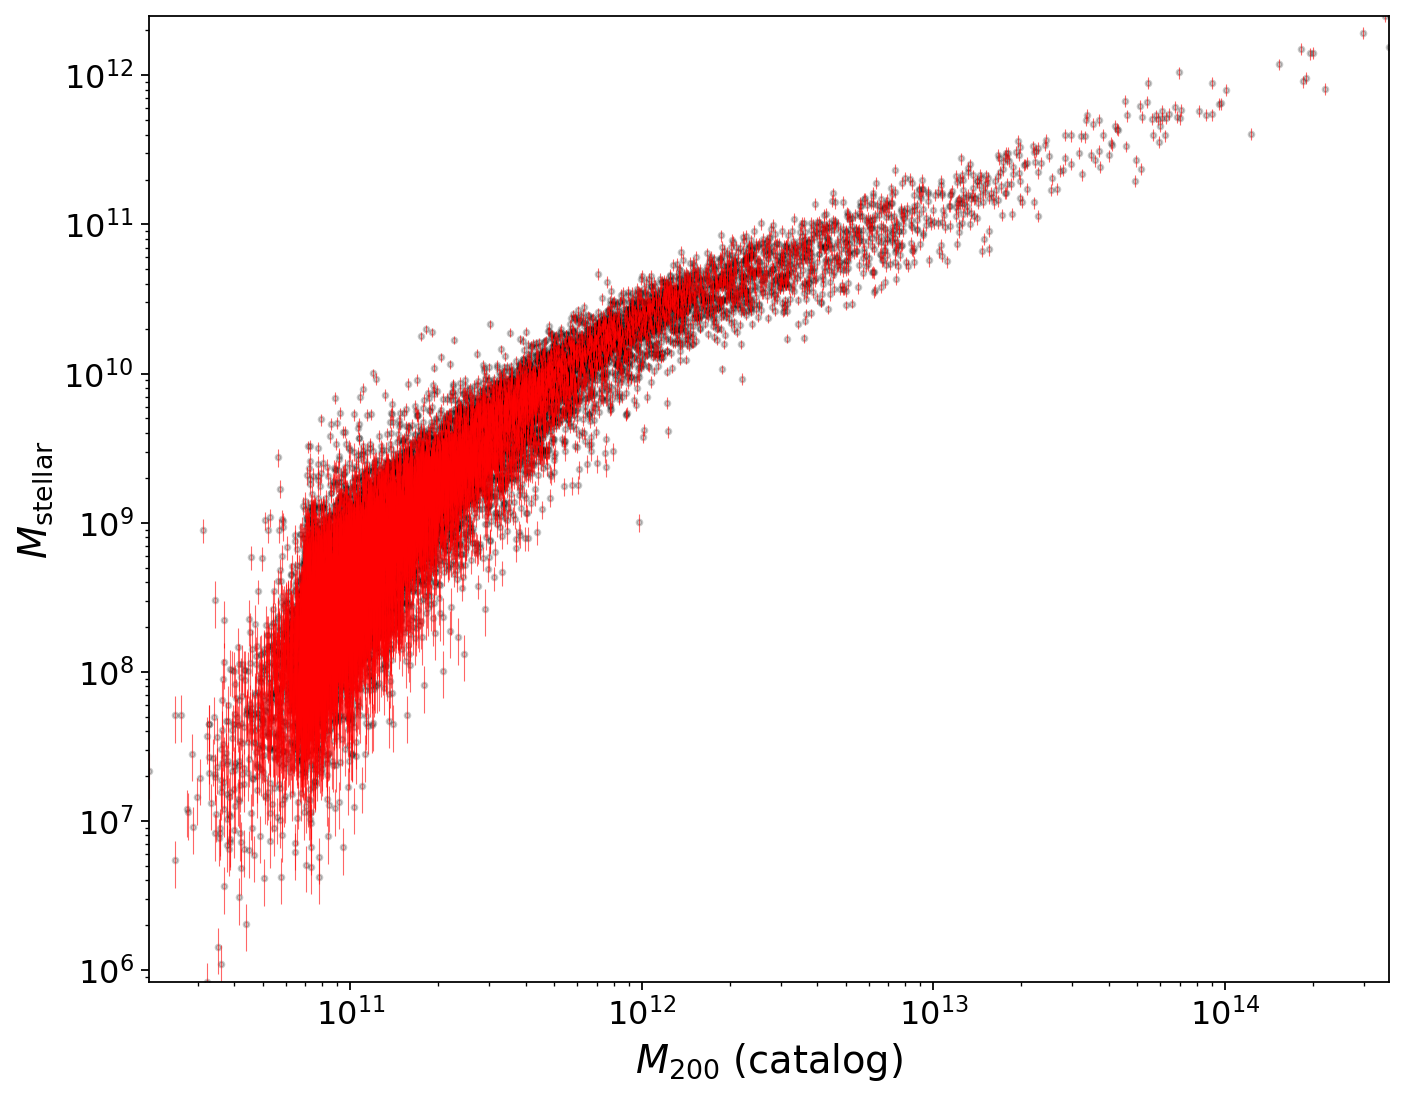

In [14]:
plt.figure(figsize=(10,8))

mdm = m200_halo*mass_multiplier
mstellar = featurizer.y_scalar*mass_multiplier
plt.scatter(mdm, mstellar, color='k', s=6, alpha=0.2)
plt.errorbar(mdm, mstellar, yerr=uncertainties*mass_multiplier, color='red', lw=0, elinewidth=0.5, alpha=0.6)

plt.xscale('log')
plt.yscale('log')
xlim = min(mdm), max(mdm)
plt.xlim(xlim)
ylim = min(mstellar), max(mstellar)
plt.ylim(ylim)

plt.xlabel(r'$M_\mathrm{200}$ (catalog)')
plt.ylabel(r'$M_\mathrm{stellar}$')

In [15]:
print(featurizer.N_halos)

20098


Computing/loading geometric features for n_rbins = 4
Geometric features exist, loading from ../data/features/features_TNG100-1/halos_nstarmin1_hmassmin1e10.8_mdifffac3.0/geometric_features_larr012*_parr0*_rbins4.npy
AtCinvA condition number: 531913494434801.188


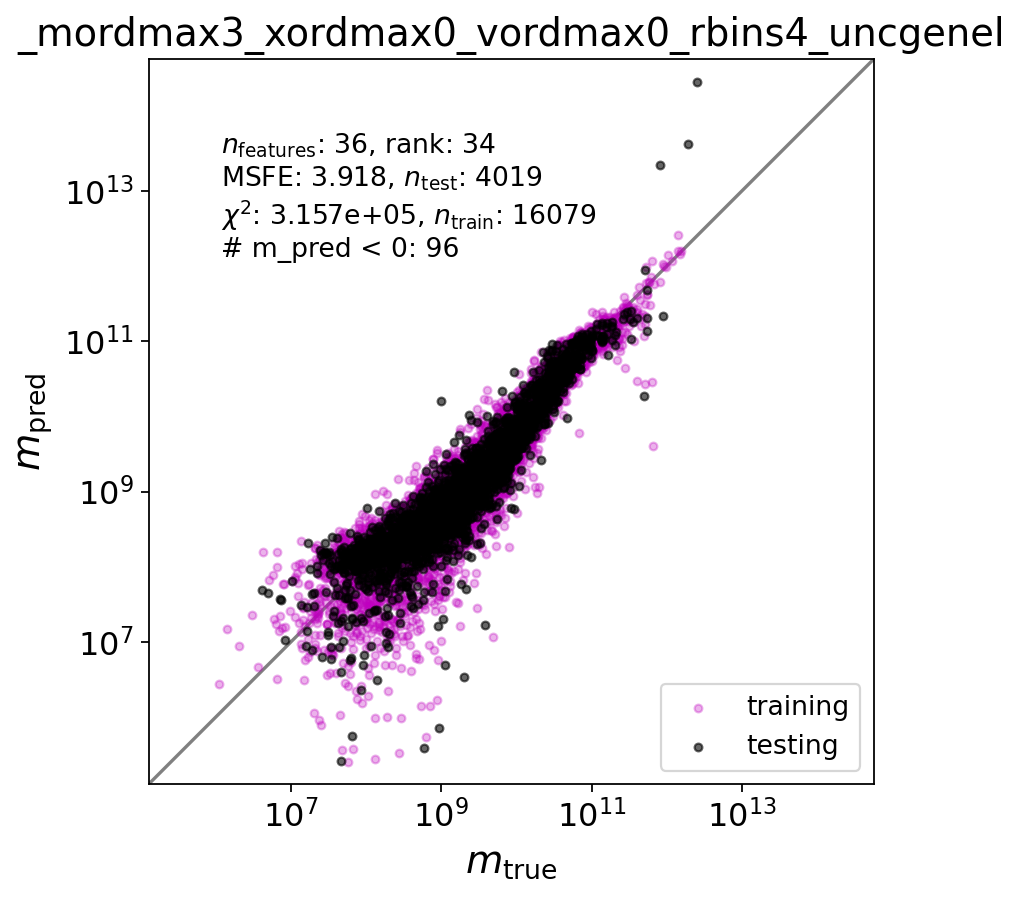

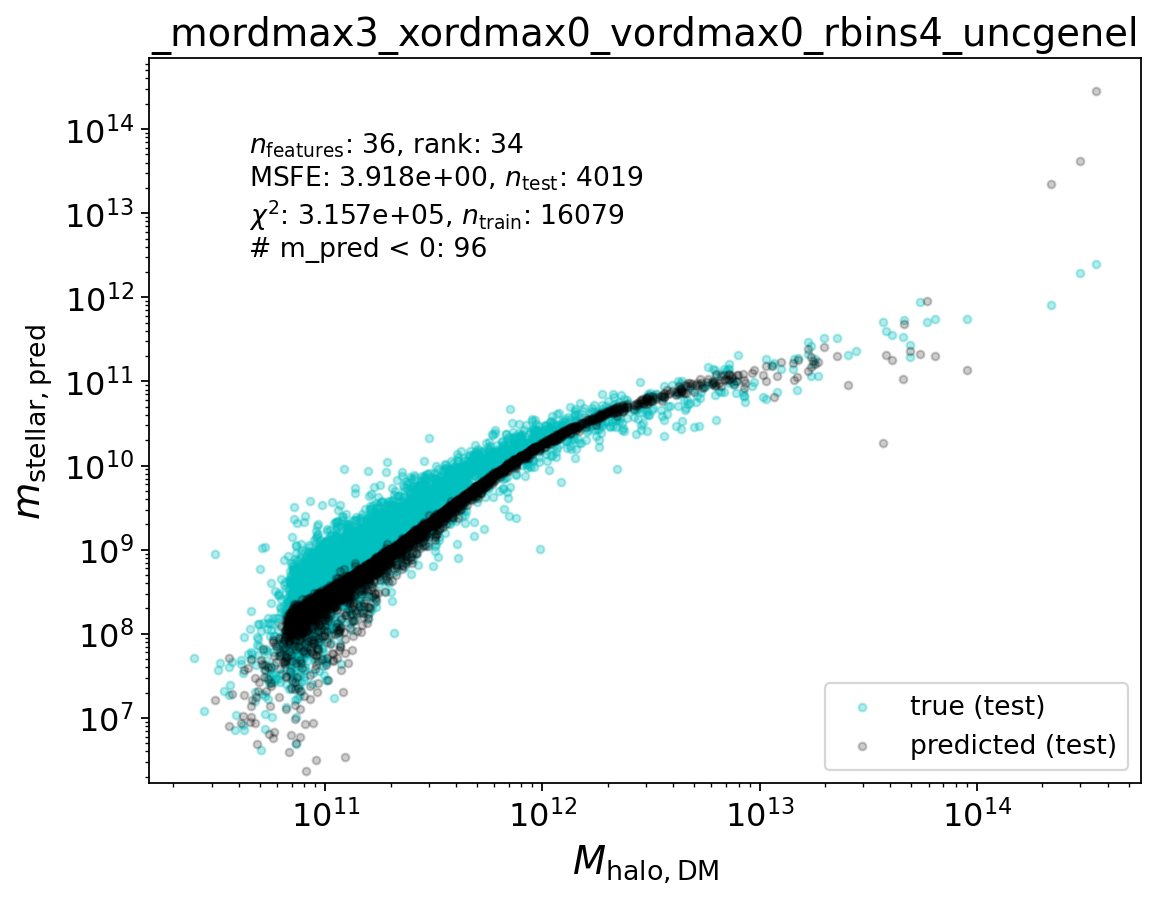

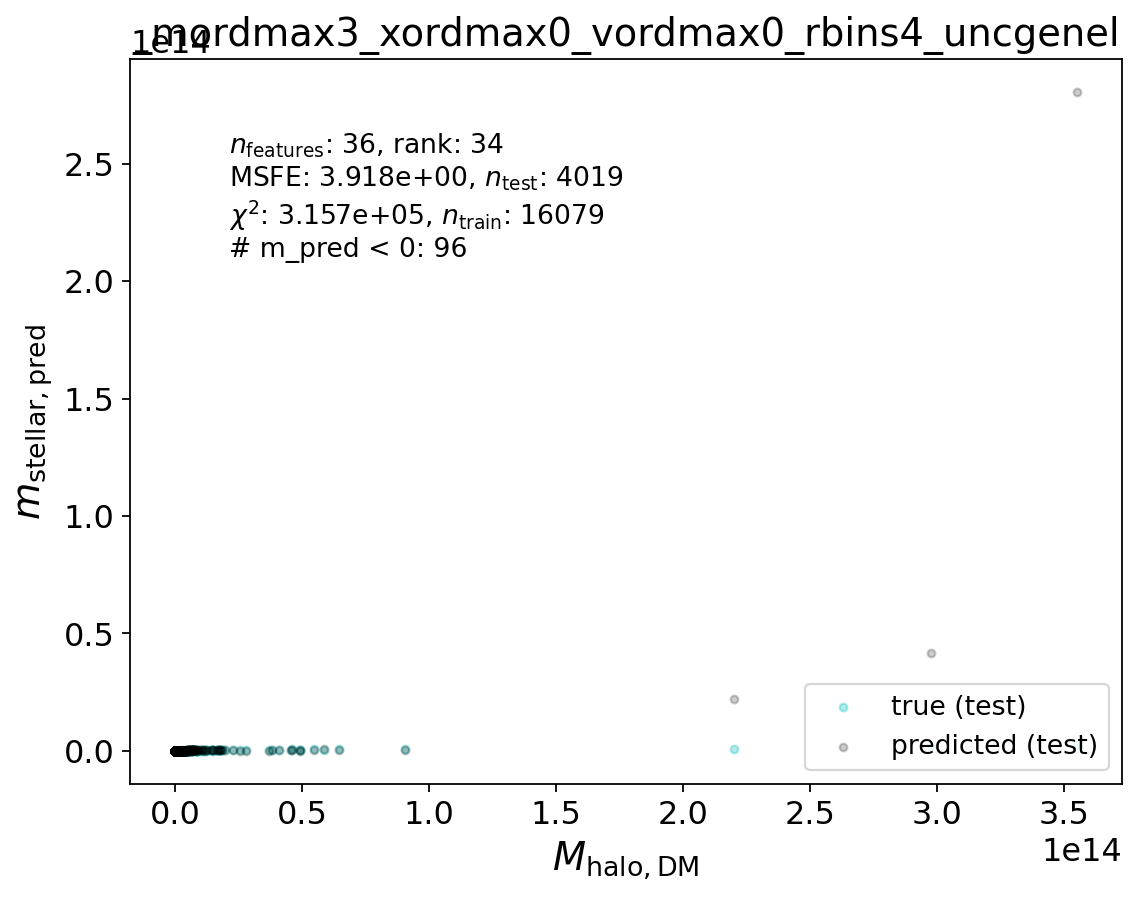

In [16]:
for n_rbins in n_rbins_arr:
    
    r_edges = np.linspace(0, 1, n_rbins+1)
    print("Computing/loading geometric features for n_rbins =", n_rbins)
    featurizer.compute_geometric_features(r_edges, l_arr, p_arr, r_units=r_units)
        
    for m_order_max in m_order_max_arr:
        for x_order_max in x_order_max_arr:
            for v_order_max in v_order_max_arr:

                feature_tag = f'_mordmax{m_order_max}_xordmax{x_order_max}_vordmax{v_order_max}_rbins{n_rbins}'
                feature_fn = f'{feature_dir}/scalar_features{feature_tag}.npy'
                featurizer.load_x_scalar_features(feature_fn)

                # Fit to those features
                fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                                y_val_current, uncertainties=uncertainties)
                fitter.split_train_test()
                fitter.scale_and_fit(rms_x=rms_x, log_x=log_x, log_y=log_y, check_cond=check_cond)
                fitter.predict_test()
                
                if show_intermediate_plots:
                    plot_eigenvalues(fitter)
                
                u, s, v = np.linalg.svd(fitter.AtCinvA, full_matrices=False)
                print(f'AtCinvA condition number: {np.max(s)/np.min(s):.3f}')
                
                # Extract arrays and plot
                y_true = fitter.y_scalar_test*mass_multiplier
                y_pred = fitter.y_scalar_pred*mass_multiplier
                msfe_test = np.mean(((y_pred - y_true)/y_true)**2)

                y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train)*mass_multiplier
                y_train_true = fitter.y_scalar_train*mass_multiplier
                chi2_train = fitter.chi2

                save_tag = f'{feature_tag}{tag}'
                save_fn = f'{plot_dir}/mass_recovery{save_tag}.png'
                plotter.plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                                          fitter, msfe_test, chi2_train, mass_multiplier,
                                          title=save_tag, save_fn=save_fn)

                masses_all = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])*mass_multiplier
                mass = masses_all[fitter.idx_test]
                mass_train = masses_all[fitter.idx_train]

                if show_intermediate_plots and n_rbins==1:
                    plot_feature_vs_mass(masses_all, featurizer)

                save_fn = f'{plot_dir}/mass_vs_pred{save_tag}.png'
                plotter.plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train_true, y_train_pred, 
                              fitter, msfe_test, chi2_train, mass_multiplier,
                              title=save_tag, save_fn=save_fn)
                
                plotter.plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train_true, y_train_pred, 
                              fitter, msfe_test, chi2_train, mass_multiplier,
                              title=save_tag, save_fn=save_fn,
                              logx='linear', logy='linear')